In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.8 MB/s 
     |████████████████████████████████| 182 kB 55.1 MB/s 
     |████████████████████████████████| 7.6 MB 18.1 MB/s 


In [ ]:
from torchvision.io import ImageReadMode, read_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import (
    VisionTextDualEncoderModel, 
    VisionTextDualEncoderProcessor, 
    AutoTokenizer, 
    AutoFeatureExtractor
)
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

Mounted at /content/drive


In [ ]:
model = VisionTextDualEncoderModel.from_vision_text_pretrained(
    "openai/clip-vit-base-patch32", "roberta-base"
)
# put checkpoint here
# model = VisionTextDualEncoderModel.from_pretrained("./path/to/checkpoint")

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
feat_ext = AutoFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")
processor = VisionTextDualEncoderProcessor(feat_ext, tokenizer)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.2.self_attn.q_proj.bias', 'text_model.encoder.layers.10.layer_norm1.bias', 'text_model.encoder.layers.6.layer_norm2.weight', 'text_model.encoder.layers.8.self_attn.out_proj.weight', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.2.layer_norm2.bias', 'text_model.encoder.layers.0.layer_norm2.weight', 'text_model.encoder.layers.6.self_attn.out_proj.bias', 'text_model.encoder.layers.2.self_attn.q_proj.weight', 'text_model.encoder.layers.10.self_attn.q_proj.weight', 'text_model.encoder.layers.3.self_attn.k_proj.weight', 'text_model.encoder.layers.1.self_attn.out_proj.bias', 'text_model.encoder.layers.10.self_attn.v_proj.bias', 'text_model.encoder.layers.0.self_attn.q_proj.weight', 'text_model.encoder.layers.7.mlp.fc2.bias', 'text_model.encoder.layers.9.self_attn.out_proj.weight', 'text_model.encoder.layers.6.self_a

AttributeError: ignored

In [ ]:
class_name_lst = ['Aortic enlargement',
                    'Atelectasis',
                    'Calcification',
                    'Cardiomegaly',
                    'Consolidation',
                    'ILD',
                    'Infiltration',
                    'Lung Opacity',
                    'Nodule/Mass',
                    'Other lesion',
                    'Pleural effusion',
                    'Pleural thickening',
                    'Pneumothorax',
                    'Pulmonary fibrosis',
                    'No finding']

In [ ]:
test = pd.read_csv('drive/MyDrive/BIOMEDIN220-F2022/CS271Project/vinbigdata-chest-xray-resized-png-256x256/vindrcxr_test.csv')
test["image_fp_vivek"] = test["image_id"].apply(lambda image_id : f'drive/MyDrive/BIOMEDIN220-F2022/vinbigdata-chest-xray-resized-png-256x256/test/{image_id}.png')

In [ ]:
test.head()

,image_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,image_fp_vivek
0,e0dc2e79105ad93532484e956ef8a71a,0,1,1,1,0,1,0,0,0,0,1,0,1,0,0,drive/MyDrive/BIOMEDIN220-F2022/vinbigdata-che...
1,0aed23e64ebdea798486056b4f174424,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,drive/MyDrive/BIOMEDIN220-F2022/vinbigdata-che...
2,aa15cfcfca7605465ca0513902738b95,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,drive/MyDrive/BIOMEDIN220-F2022/vinbigdata-che...
3,665c4a6d2693dc0286d65ab479c9b169,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,drive/MyDrive/BIOMEDIN220-F2022/vinbigdata-che...
4,42da2c134b53cb5594774d3d29faac59,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,drive/MyDrive/BIOMEDIN220-F2022/vinbigdata-che...


In [ ]:
def binarize_pred(probs, threshold):
  return probs > threshold

In [ ]:
stop = 5

preds_list = []
for i, row in test.iterrows():
  if i % 100 == 0:
    print(i)
  image_fp = row["image_fp_vivek"] # image filepath to vivek's preprocessed 256x256 photos
  # print(image_fp)
  image = read_image(image_fp, mode=ImageReadMode.RGB)
  inputs = processor(text=class_name_lst, images=image, return_tensors="pt", padding=True)
  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
  preds_list.append(logits_per_image.detach().numpy())

  # probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
  # print(probs)
  # print(binarize_pred(probs, 0.07))

preds_list = np.concatenate(preds_list,axis=0)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [ ]:
df_preds = pd.DataFrame(preds_list, columns=np.arange(0,15)).assign(image_id = test['image_id'])

In [ ]:
df_preds.to_csv('drive/MyDrive/BIOMEDIN220-F2022/vindr-cxr-CLIP/clip_regular_test_preds.csv', index=False)

In [ ]:
df_preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,image_id
0,0.717465,0.720216,0.701281,0.716199,0.729001,0.722167,0.711484,0.690613,0.709361,0.700068,0.712939,0.685171,0.740720,0.706104,0.708337,e0dc2e79105ad93532484e956ef8a71a
1,0.975989,0.983465,0.966638,0.975128,0.992484,0.980919,0.969004,0.971259,0.975111,0.966490,0.978181,0.941230,0.992721,0.964511,0.971572,0aed23e64ebdea798486056b4f174424
2,0.381085,0.389575,0.375705,0.386350,0.403840,0.388590,0.379716,0.359120,0.374309,0.380603,0.383209,0.346786,0.398914,0.369557,0.379953,aa15cfcfca7605465ca0513902738b95
3,0.719217,0.722418,0.702455,0.724804,0.733196,0.716163,0.710345,0.691759,0.702372,0.697353,0.722302,0.685364,0.738046,0.706767,0.712304,665c4a6d2693dc0286d65ab479c9b169
4,0.810215,0.820444,0.798321,0.812044,0.832242,0.823423,0.815136,0.800574,0.806848,0.793419,0.813370,0.783884,0.827792,0.801711,0.807227,42da2c134b53cb5594774d3d29faac59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.433476,0.440968,0.421591,0.443789,0.449834,0.439773,0.427932,0.409785,0.422424,0.421850,0.431815,0.399022,0.461612,0.427469,0.433283,a039af299f86007d0d77da077a6def9a
2996,0.554572,0.563861,0.546349,0.559206,0.576824,0.559997,0.549587,0.533179,0.545687,0.546708,0.555556,0.523282,0.578317,0.543863,0.555804,aba3d1f5b1c04236f52a8980929b2cfa
2997,0.433204,0.438060,0.422095,0.444534,0.445153,0.430489,0.423486,0.412209,0.411127,0.415523,0.433858,0.396693,0.448380,0.421022,0.422072,6d3d6b53f358a983b486e9e03144eb62
2998,0.558579,0.568853,0.546941,0.565375,0.573729,0.563666,0.553700,0.531639,0.540675,0.547866,0.557905,0.523614,0.578222,0.542078,0.556495,d6678cb7ae39f575d35ab9da6d7cb171


In [ ]:
preds = df_preds.drop(['image_id'], axis=1).to_numpy()

In [ ]:
def get_per_class_metrics(metric_fn, targets_list, preds_list, class_weights=None):
    targets_list = targets_list.T
    preds_list = preds_list.T
    per_class_metrics = np.array([metric_fn(i,j) if len(set(i)) > 1 else np.nan for i,j in zip(targets_list, preds_list)])
    
    if class_weights is None:
        overall_metric = np.nanmean(per_class_metrics)
    else:
        overall_metric = np.nansum(class_weights * per_class_metrics)/np.nansum(class_weights)
    return overall_metric, per_class_metrics

In [ ]:
class_weights_path = 'drive/MyDrive/BIOMEDIN220-F2022/CS271Project/vinbigdata-chest-xray-resized-png-256x256/class_weights.npy'
class_weights = np.load(class_weights_path)
class_id_list = list(map(lambda x : str(x), list(range(15))))
targets = test[class_id_list].to_numpy() # np.concatenate(targets_list, axis=0)
overall_auc, aucs = get_per_class_metrics(roc_auc_score, targets, preds)

thresholded_preds = np.round(preds)

overall_acc, accs = get_per_class_metrics(accuracy_score, targets, thresholded_preds, class_weights)
overall_prec, precs = get_per_class_metrics(precision_score, targets, thresholded_preds, class_weights)
overall_recall, recalls = get_per_class_metrics(recall_score, targets, thresholded_preds, class_weights)
overall_f1, f1s = get_per_class_metrics(f1_score, targets, thresholded_preds, class_weights)


print(f"Overall AUC: {overall_auc}")
print(f"Per-Class AUCs: {aucs}")
print(f"Overall Accuracy: {overall_acc}")
print(f"Per-Class Accuracies: {accs}")
print(f"Overall Precision: {overall_prec}")
print(f"Per-Class Precisions: {precs}")
print(f"Overall Recall: {overall_recall}")
print(f"Per-Class Recalls: {recalls}")
print(f"Overall F1 Score: {overall_f1}")
print(f"Per-Class F1 Scores: {f1s}")

Overall AUC: 0.5912386115109781
Per-Class AUCs: [0.63527959 0.59265215 0.63182356 0.64990457 0.59034593 0.64881407
 0.52261539 0.58232494 0.56092462 0.58495629 0.63573231 0.60035867
 0.65573068 0.61059494 0.36652146]
Overall Accuracy: 0.5098081478804624
Per-Class Accuracies: [0.541      0.50566667 0.558      0.538      0.48166667 0.52833333
 0.52633333 0.57066667 0.545      0.54933333 0.52333333 0.59533333
 0.47566667 0.556      0.41066667]
Overall Precision: 0.043232262278987445
Per-Class Precisions: [0.0990991  0.03772336 0.08866279 0.14314115 0.03858318 0.10252996
 0.01905434 0.03905054 0.06951484 0.03953148 0.05166553 0.07207207
 0.00884397 0.09276844 0.59943781]
Overall Recall: 0.6693426626475355
Per-Class Recalls: [0.65       0.6627907  0.62886598 0.69902913 0.63541667 0.69683258
 0.46551724 0.60714286 0.54545455 0.57446809 0.68468468 0.52071006
 0.77777778 0.58525346 0.41589469]
Overall F1 Score: 0.07812488423346686
Per-Class F1 Scores: [0.17197835 0.07138384 0.15541401 0.237623

In [ ]:
print(classification_report(targets, thresholded_preds))

              precision    recall  f1-score   support

           0       0.10      0.65      0.17       220
           1       0.04      0.66      0.07        86
           2       0.09      0.63      0.16       194
           3       0.14      0.70      0.24       309
           4       0.04      0.64      0.07        96
           5       0.10      0.70      0.18       221
           6       0.02      0.47      0.04        58
           7       0.04      0.61      0.07        84
           8       0.07      0.55      0.12       176
           9       0.04      0.57      0.07        94
          10       0.05      0.68      0.10       111
          11       0.07      0.52      0.13       169
          12       0.01      0.78      0.02        18
          13       0.09      0.59      0.16       217
          14       0.60      0.42      0.49      2051

   micro avg       0.10      0.52      0.17      4104
   macro avg       0.10      0.61      0.14      4104
weighted avg       0.34   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Per-Class ROC Curves

In [ ]:
id_to_class_name = {0: 'Aortic enlargement',
                    1: 'Atelectasis',
                    2: 'Calcification',
                    3: 'Cardiomegaly',
                    4: 'Consolidation',
                    5: 'ILD',
                    6: 'Infiltration',
                    7: 'Lung Opacity',
                    8: 'Nodule/Mass',
                    9: 'Other lesion',
                    10: 'Pleural effusion',
                    11: 'Pleural thickening',
                    12: 'Pneumothorax',
                    13: 'Pulmonary fibrosis',
                    14: 'No finding'}

In [ ]:
def get_per_class_roc_curves(targets_list, preds_list):
    targets_list = targets_list.T
    preds_list = preds_list.T
    per_class_roc_curves = np.array([roc_curve(i,j) if len(set(i)) > 1 else np.nan for i,j in zip(targets_list, preds_list)])
    per_class_auc = np.array([roc_auc_score(i,j) if len(set(i)) > 1 else np.nan for i,j in zip(targets_list, preds_list)])
    
    return per_class_auc, per_class_roc_curves

In [ ]:
per_class_auc, per_class_roc_curves = get_per_class_roc_curves(targets, preds)

<ipython-input-55-b7fb99613d37>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  per_class_roc_curves = np.array([roc_curve(i,j) if len(set(i)) > 1 else np.nan for i,j in zip(targets_list, preds_list)])


AUC score = 0.6352795945062132
AUC score = 0.5926521523998022
AUC score = 0.6318235592360995
AUC score = 0.6499045722346694
AUC score = 0.5903459308999082
AUC score = 0.6488140693208111
AUC score = 0.5226153918282191
AUC score = 0.5823249395780259
AUC score = 0.5609246233582281
AUC score = 0.5849562899942891
AUC score = 0.6357323055142369
AUC score = 0.6003586664130642
AUC score = 0.6557306803785677
AUC score = 0.6105949386581796
AUC score = 0.36652145834435795


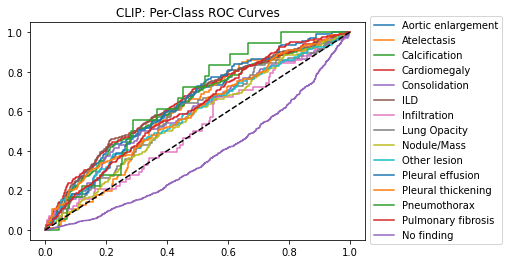

In [ ]:
for i, ((fpr, tpr, thresholds), auc) in enumerate(zip(per_class_roc_curves, per_class_auc)):
    class_name = id_to_class_name[i]
    plt.plot(fpr, tpr, label=f"{class_name}")
    print(f"AUC score = {auc}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("CLIP: Per-Class ROC Curves")
plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.05))